# Predicting the weekly return of a stock

## Import all necessary libraries

In [1]:
# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Function and modules for the supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Function and modules for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Function and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Function and modules for time series models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## Loading the data

In [3]:
# Stock tickers
stock_tickers = ['MSFT', 'IBM', 'GOOGL']

# Currency tickers from FRED (USD/JPY and GBP/USD)
ccy_tickers = ['DEXJPUS', 'DEXUSUK']

# Indices tickers from FRED (S&P500, Dow Jones Industrial Avg and VIX)
indices_tickers = ['SP500', 'DJIA', 'VIXCLS']

stock_data = web.DataReader(stock_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
indices_data = web.DataReader(indices_tickers, 'fred')

In [4]:
stock_data.head()

Attributes  Adj Close                             Close              \
Symbols          MSFT         IBM      GOOGL       MSFT         IBM   
Date                                                                  
2017-08-14  68.928352  107.266548  46.946499  73.589996  136.061188   
2017-08-15  68.947182  107.078110  46.903999  73.220001  135.822174   
2017-08-16  69.352097  107.402206  47.213501  73.650002  136.233276   
2017-08-17  68.175026  106.045532  46.382999  72.400002  134.512421   
2017-08-18  68.259796  105.291840  46.308998  72.489998  133.556412   

Attributes                  High                               Low  \
Symbols         GOOGL       MSFT         IBM      GOOGL       MSFT   
Date                                                                 
2017-08-14  46.946499  73.720001  136.481842  47.051998  72.949997   
2017-08-15  46.903999  73.589996  137.036331  47.153500  73.040001   
2017-08-16  47.213501  74.099998  136.625244  47.494999  73.169998   
2017-08-17  46.382999  73.870003  136.606125  47.190498  72.400002   
2017-08-18  46.308998  72.839996  134.942642  46.550999  71.930000   

Attributes                              Open                         \
Symbols            IBM      GOOGL       MSFT         IBM      GOOGL   
Date                                                                  
2017-08-14  135.697891  46.724499  73.059998  135.755264  46.953499   
2017-08-15  134.397705  46.832001  73.589996  136.281067  47.051498   
2017-08-16  135.382416  47.001999  73.339996  135.554489  47.062500   
2017-08-17  134.512421  46.382000  73.580002  136.252396  47.147499   
2017-08-18  133.441681  46.172501  72.269997  134.674957  46.348999   

Attributes      Volume                         
Symbols           MSFT        IBM       GOOGL  
Date                                           
2017-08-14  20096600.0  2352036.0  23012000.0  
2017-08-15  19181400.0  4896849.0  22130000.0  
2017-08-16  18150400.0  3439039.0  26906000.0  
2017-08-17  22977500.0  4625517.0  33914000.0  
2017-08-18  18761500.0  4343724.0  26748000.0

In [5]:
ccy_data.head()

,DEXJPUS,DEXUSUK
DATE,,
2017-08-14,109.48,1.2975
2017-08-15,110.42,1.2862
2017-08-16,110.80,1.2860
2017-08-17,109.88,1.2888
2017-08-18,109.32,1.2847


In [6]:
indices_data.head()

,SP500,DJIA,VIXCLS
DATE,,,
2017-08-14,2465.84,21993.71,12.33
2017-08-15,2464.61,21998.99,12.04
2017-08-16,2468.11,22024.87,11.74
2017-08-17,2430.01,21750.73,15.55
2017-08-18,2425.55,21674.51,14.26


In [7]:
print(stock_data.shape)
print(ccy_data.shape)
print(indices_data.shape)

(1258, 18)
(1300, 2)
(1304, 3)


We get about 5 years worth of individual stock price, currency and indices prices data to work with.

## Define x and y variables
- y variable is the weekly return of the stock (in this case Microsoft)
- Number of trading days assumed to be five
- Independent or x variables:
    - Use correlated assets (currencies and indices) and historical returns of stock
    - Lagged five days return of stocks, currencies and indices
    - Lagged 5-day, 15-day, 30-day and 60-day of stock

In [8]:
# Define number of trading days
return_period = 5

# Set the y variable
# We will take the log of the Adjusted Close, then find the discrete difference over a 5-day period
# We then shift this 5-day difference back by 5 trading days
y = np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

# Rename the variable with "stock_ticker" & "pred" from the MultiIndex of Attribute & Symbols
y.name = y.name[-1] + '_pred'

In [9]:
y.head()

Date
2017-08-14   -0.014448
2017-08-15   -0.000820
2017-08-16   -0.012708
2017-08-17    0.003998
2017-08-18    0.004542
Name: MSFT_pred, dtype: float64

In [10]:
# Log stock prices, then find the 5-day return
# Drop level to change from Multi Index to single index
x1 = np.log(stock_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
x1.columns = x1.columns.droplevel()

# Log currency rates, then find the 5-day return
x2 = np.log(ccy_data).diff(return_period)

# Log indices level, then find the 5-day return
x3 = np.log(indices_data).diff(return_period)

# Find the 5-day, 15-day, 30-day and 60-day returns of MSFT stock
# Concat on the columns, then drop all the null rows
x4 = pd.concat([np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).\
                diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]],\
               axis=1).dropna()

# Rename the columns according to the return period
x4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [11]:
# Concat all the previous dataframes into one along columns axis
X = pd.concat([x1, x2, x3, x4], axis=1)

# Join y and x together into a single dataframe, drop null rows
# Slice df in intervals of 5 to get the weekly returns
df = pd.concat([y, X], axis=1).dropna().iloc[::return_period, :]

In [12]:
# Final dataset of weekly stock returns
df.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-11-07,-0.002614,0.018558,-0.017747,0.002373,-0.009761,0.005954,0.007670,-0.028901,0.013019,0.082587,0.140011,0.140831
2017-11-15,0.001565,-0.020892,-0.019989,-0.004145,0.004339,-0.011537,-0.012473,0.294560,-0.013852,0.058856,0.110263,0.130961
2017-11-24,0.011939,0.007649,0.018076,-0.003937,0.008585,0.009098,0.008515,-0.167213,0.000721,-0.004434,0.081615,0.122777
2017-12-04,0.049917,-0.057735,0.029052,0.016086,0.009852,0.014509,0.029635,0.168378,-0.033832,-0.028822,0.033406,0.096651
2017-12-11,0.013403,0.038865,-0.006734,0.004776,-0.007604,0.007756,0.003944,-0.223572,0.049917,0.033768,0.021811,0.128750


In [13]:
# Separate into X and y variables
y = df.loc[:, y.name]
X = df.loc[:, X.columns]

## EDA: Exploratory Data Analysis

In [14]:
df.isnull().sum()

MSFT_pred    0
GOOGL        0
IBM          0
DEXJPUS      0
DEXUSUK      0
SP500        0
DJIA         0
VIXCLS       0
MSFT_DT      0
MSFT_3DT     0
MSFT_6DT     0
MSFT_12DT    0
dtype: int64

In [15]:
df.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.005981,0.003219,0.000163,0.000606,-0.000764,0.001840,0.001285,-0.001412,0.005483,0.015999,0.033383,0.066953
std,0.031509,0.037896,0.036127,0.009998,0.012317,0.024938,0.025616,0.167839,0.032959,0.051937,0.068472,0.090564
min,-0.120414,-0.131484,-0.156919,-0.035716,-0.073460,-0.130665,-0.163839,-0.447131,-0.120414,-0.153241,-0.237924,-0.213763
25%,-0.011287,-0.019170,-0.018287,-0.004576,-0.007604,-0.006367,-0.008571,-0.096768,-0.015363,-0.011635,-0.005924,0.013243
50%,0.009496,0.007727,0.001202,0.000574,-0.000579,0.003316,0.003016,-0.021589,0.008595,0.022519,0.043594,0.075440
75%,0.024201,0.026217,0.021962,0.005587,0.008062,0.015039,0.012371,0.071139,0.025487,0.046981,0.079866,0.128750
max,0.088731,0.135595,0.092025,0.036833,0.055299,0.062473,0.079118,0.991966,0.088731,0.147290,0.244063,0.306231


### Visualisation using a correlation heatmap

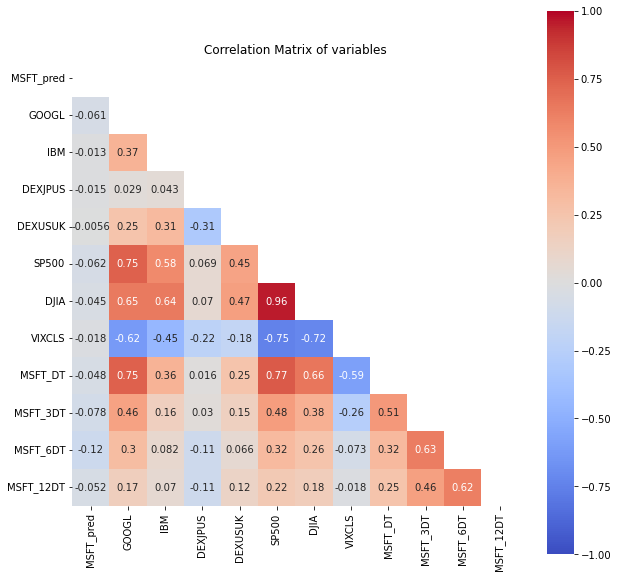

In [16]:
# Find the correlation between the variables
df_corr = df.corr()

# Masking the plot
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)]=True

# Plot the heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix of variables')
sns.heatmap(df_corr, vmax=1, vmin=-1, square=True, annot=True, cmap='coolwarm', mask=mask);

There seems to be some correlation of the predicted variable with the lagged 5 days, 15 days, 30 days and 60 days return of the stock.

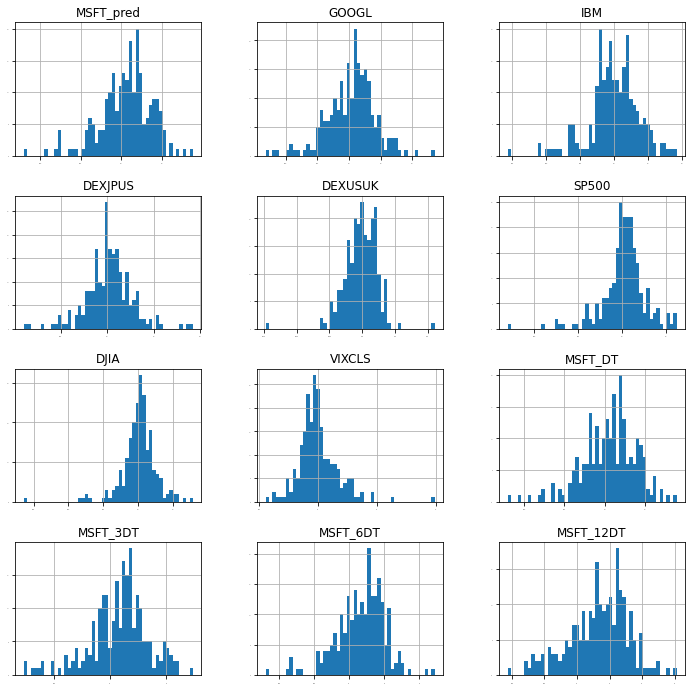

In [17]:
# distribution of each series individually
df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show();

<Figure size 1080x1080 with 0 Axes>

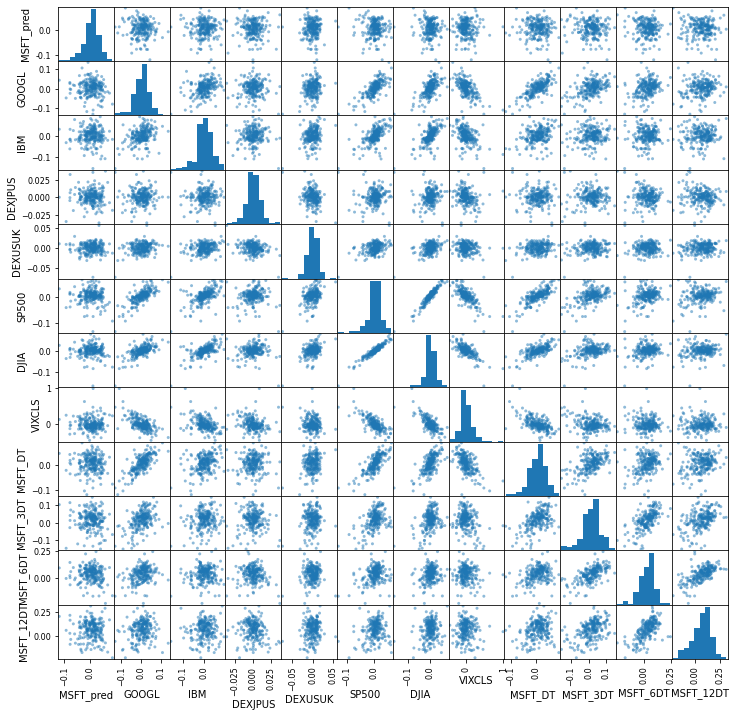

In [18]:
plt.figure(figsize=(15,15))
scatter_matrix(df,figsize=(12,12))
plt.show();

There seems to be some sort of linear relationship between the predicted variable and the lagged returns.

## Time series analysis

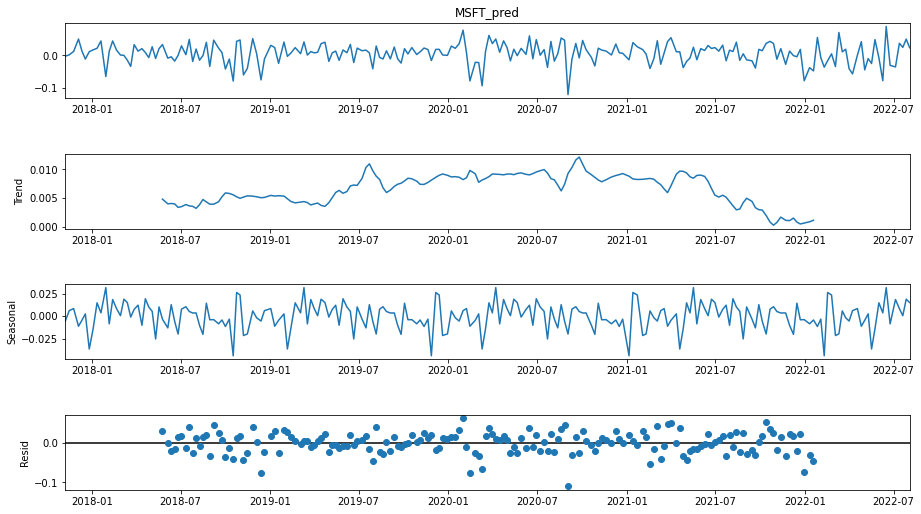

In [19]:
res = sm.tsa.seasonal_decompose(y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show();

We can see that for MSFT there has been a general trend downwards. This should show up in our constant/bias terms in our models.

## Feature Selection
- We use sklearn's SelectKBest function to get a sense of feature importance.

In [20]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,3.512947
MSFT_3DT,1.371418
SP500,0.867526
GOOGL,0.829908
MSFT_12DT,0.611974
MSFT_DT,0.506111
DJIA,0.446577
VIXCLS,0.069096
DEXJPUS,0.049327


We see that the 30 days lagged return is the most important feature, while the DJIA is the least important.

## Train-test split

In [21]:
validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
# seed = 42
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [22]:
num_folds = 10
seed = 42
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## Models

In [23]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [24]:
# Neural network algorithms
models.append(('MLP', MLPRegressor()))

In [25]:
# Ensemble models algorithms

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. 
1. First we run the K-fold analysis. 
2. Next we run the model on the entire training and testing dataset

In [26]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Converted mean square error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, y_train)
    train_result = mean_squared_error(res.predict(X_train), y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001012 (0.000575) 0.000823 0.001671
LASSO: 0.000886 (0.000491) 0.000873 0.001463
EN: 0.000886 (0.000491) 0.000873 0.001463
KNN: 0.001112 (0.000417) 0.000682 0.001593
CART: 0.001733 (0.000584) 0.000000 0.003347
SVR: 0.001746 (0.000447) 0.001727 0.001842
MLP: 0.002201 (0.001313) 0.000968 0.001604
ABR: 0.001017 (0.000454) 0.000464 0.001690
GBR: 0.001276 (0.000504) 0.000091 0.002119
RFR: 0.001074 (0.000437) 0.000140 0.001961
ETR: 0.001020 (0.000451) 0.000000 0.001878


### K-fold results

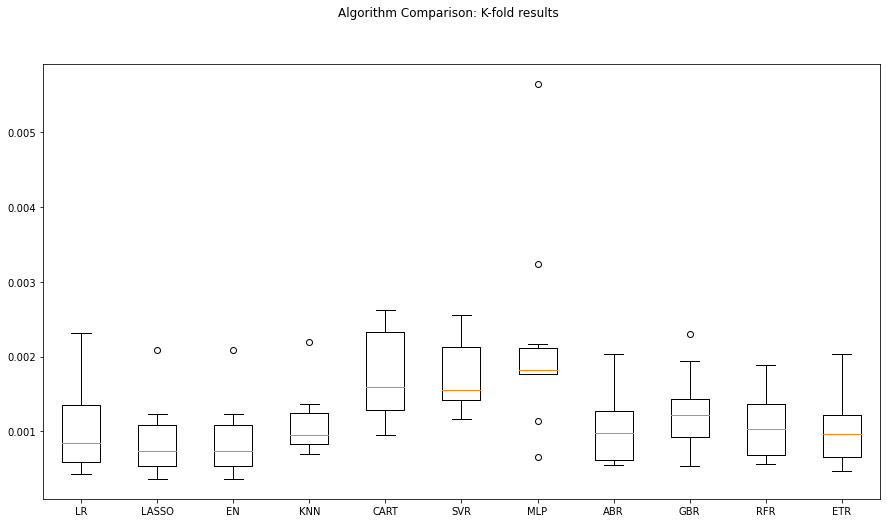

In [27]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: K-fold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show();

## Training and Test error

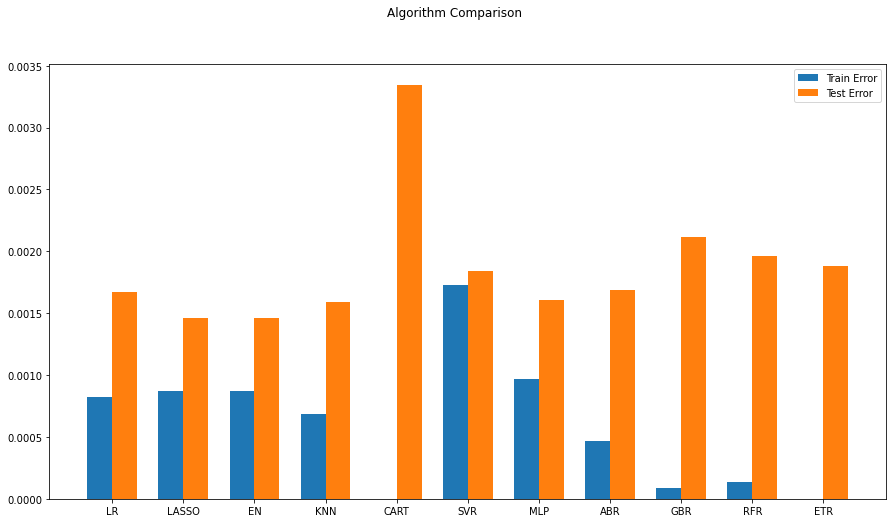

In [28]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()